In [2]:
# !pip install vitaldb

In [3]:
import vitaldb
import matplotlib.pyplot as plt

## Get the Union of Cases

In [4]:
# outcome: ART (Arterial pressure wave)
# features: ECG_II, PLETH, CO2

# phenylephrine, vasopressin, epinephrine
# optimal control variables are: PHEN_RATE, NEPI_RATE, VASO_RATE

optimal_control_vars = ["PHEN_RATE", "NEPI_RATE", "VASO_RATE"]
all_cases = []

features = ["ART", "ECG_II", "PLETH", "CO2"]

for var in optimal_control_vars:
    features.append(var)
    print("Finding cases with features: ", features)
    all_cases.append(vitaldb.find_cases(features))
    print("Number of cases found: ", len(all_cases[-1]))
    features.remove(var)

Finding cases with features:  ['ART', 'ECG_II', 'PLETH', 'CO2', 'PHEN_RATE']
Number of cases found:  103
Finding cases with features:  ['ART', 'ECG_II', 'PLETH', 'CO2', 'NEPI_RATE']
Number of cases found:  61
Finding cases with features:  ['ART', 'ECG_II', 'PLETH', 'CO2', 'VASO_RATE']
Number of cases found:  1


In [5]:
# Union the cases
all_cases = list(set().union(*all_cases))

In [6]:
print("Total cases: ", len(all_cases))
print("Sample of cases: ", all_cases[:10])

Total cases:  159
Sample of cases:  [513, 3585, 1537, 521, 4618, 527, 6160, 17, 20, 5142]


In [7]:
# For now we'll just use PHEN_RATE

features = ["ART", "ECG_II", "PLETH", "CO2", "PHEN_RATE"]
cases = vitaldb.find_cases(features)
print("Number of cases found: ", len(cases))

Number of cases found:  103


## Table: Hemodynamics
- Time series

In [8]:
print(f"Feature set: {features}")

Feature set: ['ART', 'ECG_II', 'PLETH', 'CO2', 'PHEN_RATE']


In [10]:
# 1/100 is 0.01 sec interval = 100 Hz sampling rate
# 1 is 1 sec interval = 1 Hz sampling rate
from tqdm import tqdm

values_for_all_cases = {}

for case in tqdm(cases):
    vals = vitaldb.load_case(case, features, interval=1)
    values_for_all_cases[case] = vals

100%|██████████| 103/103 [14:32<00:00,  8.47s/it]


In [ ]:
# to pandas dataframe
# check null value
import pandas as pd

rows = []
for k, arr in values_for_all_cases.items():
    for row in arr:
        rows.append([k] + list(row))

df = pd.DataFrame(rows, columns=["id"] + features)
print(df.head())

    id      ART    ECG_II      PLETH  CO2  PHEN_RATE
0  513      NaN       NaN        NaN  NaN        NaN
1  513  5.01471  0.622872  30.839600  0.0        NaN
2  513  5.01471  0.741367  74.682701  0.0        NaN
3  513  5.01471  0.069896  37.554298  0.0        NaN
4  513  5.01471  0.198266  54.933601  0.0        NaN


In [ ]:
print("Percentage of missing values per column:")
(df.isna().sum() / len(df)) * 100

Percentage of missing values per column:


id            0.000000
ART           0.969561
ECG_II        0.969561
PLETH         0.969561
CO2           0.217547
PHEN_RATE    55.877070
dtype: float64

In [24]:
# add time column
time = [i + 1 for i in range(len(df))]
df["time"] = time

In [ ]:
# take a only a subset of time series for easier visualization
subset_df = df[df["id"] == cases[0]]
subset_df = subset_df[subset_df["time"] <= 300]  # first 5 minutes

In [26]:
ecg = subset_df["ECG_II"]
art = subset_df["ART"]
co2 = subset_df["CO2"]
phen_rate = subset_df["PHEN_RATE"]
pleth = subset_df["PLETH"]

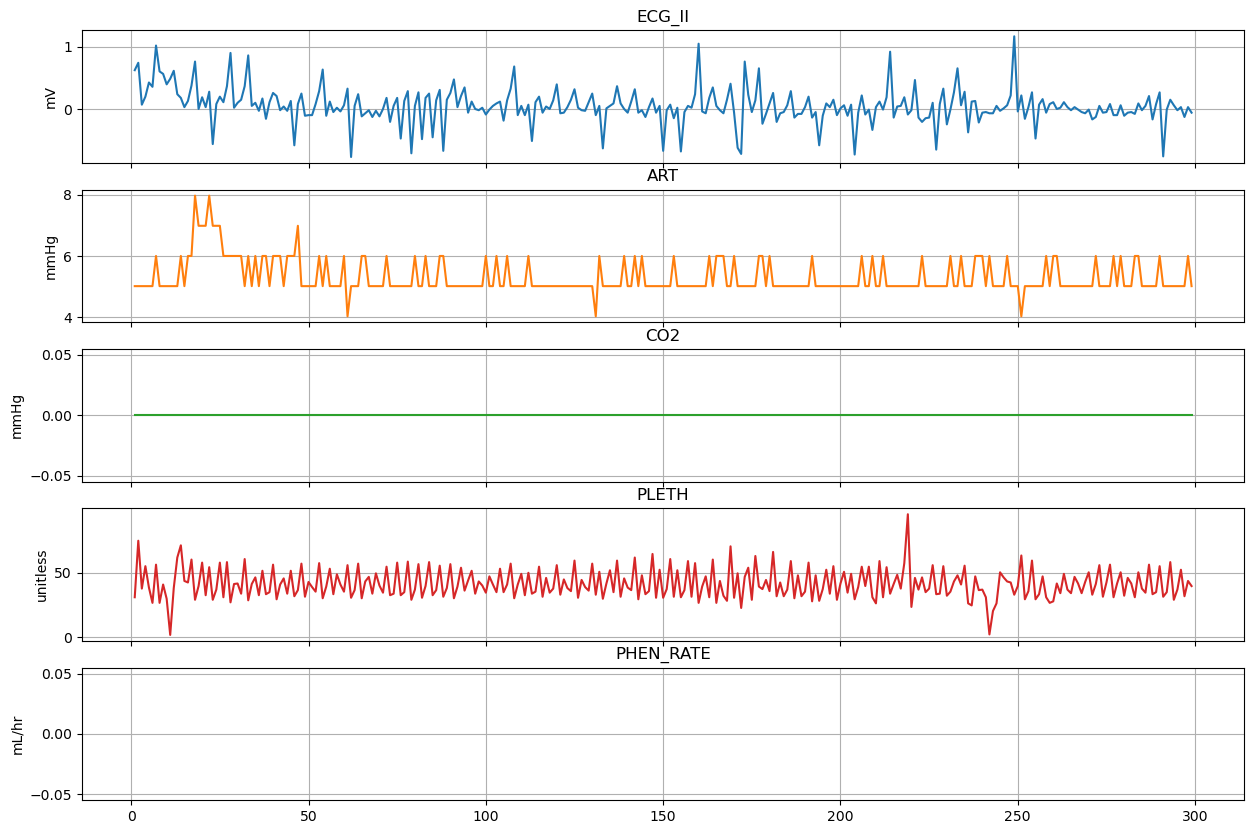

In [27]:
fig, ax = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

ax[0].plot(ecg, color="tab:blue")
ax[0].set_title("ECG_II")
ax[0].set_ylabel("mV")
ax[0].grid()

ax[1].plot(art, color="tab:orange")
ax[1].set_title("ART")
ax[1].set_ylabel("mmHg")
ax[1].grid()

ax[2].plot(co2, color="tab:green")
ax[2].set_title("CO2")
ax[2].set_ylabel("mmHg")
ax[2].grid()

ax[3].plot(pleth, color="tab:red")
ax[3].set_title("PLETH")
ax[3].set_ylabel("unitless")
ax[3].grid()

ax[4].plot(phen_rate, color="tab:purple")
ax[4].set_title("PHEN_RATE")
ax[4].set_ylabel("mL/hr")
ax[4].grid()

plt.show()

In [28]:
df.to_csv("vitaldb_all_cases.csv", index=False)

## Table: Clinical Information

In [29]:
import pandas as pd
import requests
from io import StringIO

# URL for the clinical cases
url = "https://api.vitaldb.net/cases"

resp = requests.get(url)
resp.raise_for_status()

# The response is a gzipped CSV. VitalDB docs say it's CSV compressed with gzip
# But requests will give you the raw bytes; if it's compressed, decompress, or
# alternatively, use pandas read_csv with compression

# Decode the bytes into text
csv_text = resp.content.decode("utf-8-sig")  # strip BOM if present

# Read as plain CSV
cases_df = pd.read_csv(StringIO(csv_text))

# # Now you have a dataframe with e.g. columns:
# # 'caseid', 'age', 'sex', 'opname', plus many others

# # Example: show case 1
# print(cases_df.loc[cases_df['caseid'] == 1, ['age', 'sex', 'opname']])

In [30]:
cases_df.columns

Index(['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend',
       'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age',
       'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype',
       'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn',
       'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt',
       'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc',
       'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr',
       'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2',
       'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize',
       'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl',
       'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid',
       'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn',
       'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe',
       'intraop_epi', 'intraop_ca'],
     

In [34]:
cases_df = cases_df[cases_df["caseid"].isin(cases)].head()
cases_df.head()

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
19,20,2419,0,26476,86,27086.0,3386,25875,-822780,1164420,...,500,0,0.0,0,180,0,5,250,0,600
27,28,2782,0,26902,-258,27162.0,2862,25662,-131220,646380,...,500,0,0.0,0,170,0,0,400,0,0
60,61,2402,0,9291,-1425,9075.0,1875,8175,-133980,384420,...,0,90,0.0,0,60,0,15,60,0,0
162,163,3131,0,4969,-366,4134.0,1734,3834,-2148660,5800140,...,0,0,0.0,0,80,0,0,500,0,0
184,185,5793,0,12997,-349,12851.0,3251,11771,-52500,984300,...,0,110,0.0,100,120,0,0,30,0,0


In [35]:
cases_df["opname"].value_counts()

opname
Lung lobectomy            1
Thymectomy                1
Hemihepatectomy           1
Debridement of wound      1
Exploratory laparotomy    1
Name: count, dtype: int64

In [36]:
cases_df.to_csv("vitaldb_clinical_info.csv", index=False)

## Table: Lab Results

In [37]:
import pandas as pd
import requests
from io import StringIO

# URL for the clinical cases
url = "https://api.vitaldb.net/labs"

resp = requests.get(url)
resp.raise_for_status()

# The response is a gzipped CSV. VitalDB docs say it's CSV compressed with gzip
# But requests will give you the raw bytes; if it's compressed, decompress, or
# alternatively, use pandas read_csv with compression

# Decode the bytes into text
csv_text = resp.content.decode("utf-8-sig")  # strip BOM if present

# Read as plain CSV
labs_df = pd.read_csv(StringIO(csv_text))

# # Now you have a dataframe with e.g. columns:
# # 'caseid', 'age', 'sex', 'opname', plus many others

# # Example: show case 1
# print(cases_df.loc[cases_df['caseid'] == 1, ['age', 'sex', 'opname']])

In [46]:
lab_subset = labs_df[labs_df["caseid"].isin(cases)]

In [48]:
lab_subset.to_csv("lab_table.csv", index=False)

VitalDB Notes
- The time interval is 0.01 seconds
- We have three datasets: 
    - clinical information (cross sectional)
    - hemodynamic parameters (time series)
    - pre-op lab results (cross sectional)
- The most popular surgery types are for cancer

PulseDB
- derived from VitalDB
- https://www.kaggle.com/code/mineshjethva/eda-pulsedb


Drug List
- amiodarone
- dexmedetomidine
- dobutamine
- dopamine
- dilitiazem
- epinephrine
- futhan
- milrinone
- norepinephrine
- nitroprusside
- nitroglycerin
- oxytocin
- prostaglandin
- phenylephrine
- propofol
- remifentanil
- rocuronium
- vasopressin
- vecuronium

Control
- Vasopressors: norepinephrine, phenylephrine, vasopressin, epinephrine

Outcome
- ABP
X
- ABP
- PLETH
- CO2
- ECG

Papers
1. https://ieeexplore.ieee.org/abstract/document/10821970
- transformer based classifier for intraoperative hypotension (binary outcome)
2. https://www.mdpi.com/1424-8220/23/22/9057
- measures cardiac output (regression)
- uses only two time series as features (PPG and ART)
3. https://iris.uniroma1.it/handle/11573/1714175
- remote patient monitoring system

Notes
- a lot of papers in the medical field are binary outcomes
- the cancer papers relied on genetics knowledge and were primarily cell based. Drug response is the response of a drug on a cell line

             <!-- PAST HISTORY
   +--------------------------------+
   | ABP  | HR  | SpO2 | EtCO2 | u  |
   +--------------------------------+
           (T_enc timesteps)
                    |
                    v
                 ENCODER
          (summarizes patient state)
                    |
               hidden state
                    |
          ------------------------
          |                      |
          v                      v
     DECODER INPUT           DECODER INPUT
  (prev ABP + zeros u)     (prev ABP + planned u)
          |                      |
          v                      v
     DECODER STEP 1          DECODER STEP 1
          |                      |
          v                      v
     Pred ABP t+1            Pred ABP t+1
          |                      |
          v                      v
     DECODER STEP 2          DECODER STEP 2
          |                      |
          v                      v
      ...                     ...
          |                      |
          v                      v
     Pred ABP t+H            Pred ABP t+H
          |                      |
          +----------------------+
          |
     Compare trajectories:
      - With zeros → ABP without intervention
      - With planned u → ABP under intervention -->


Use Case
- for doctors and nurses in either recovery or urgent care, not for surgery
- for remote patient monitoring and as a stop gap in case no one is available then the system will first alert then kick in to administer drugs (last resort system for overloaded hospitals)
- good for rural hospitals with limited staff and resources

In [ ]:
import numpy as np

E = np.array([[1, 0, -1], [-3 / 2, 0, 2], [1 / 2, 1, 0]])

np.linalg.inv(E) @ np.array([0, 0, 1])

array([0., 1., 0.])

## Google Bucket Test

In [ ]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""

In [ ]:
import pandas as pd

bucket_name = "dosewisedb"
file_path_in_bucket = "hemodyn_table.csv"

# Directly read from GCS
df = pd.read_csv(f"gs://{bucket_name}/{file_path_in_bucket}")

print(df.head())

       ART  CO2    ECG_II  PHEN_RATE      PLETH  time
0      NaN  NaN       NaN        NaN        NaN     1
1  5.01471  0.0  0.622872        NaN  30.839600     2
2  5.01471  0.0  0.741367        NaN  74.682701     3
3  5.01471  0.0  0.069896        NaN  37.554298     4
4  5.01471  0.0  0.198266        NaN  54.933601     5


<Axes: >

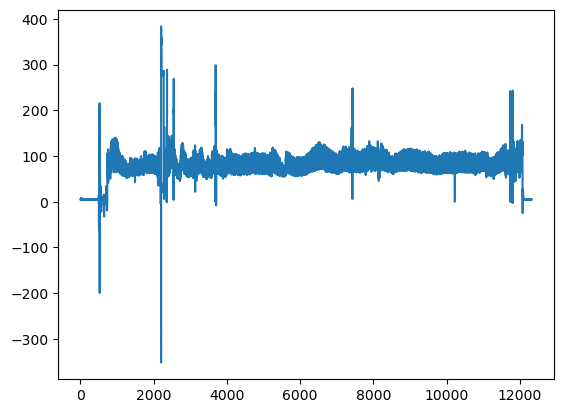

In [ ]:
df["ART"].dropna().plot()